# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Disable the specific warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Load Feature File
df = pd.read_csv("../TeamSeasons_2025.csv")

## Basic Seed Exploration

In [8]:
tourney_teams = df[df['Seed'].notna()]

In [9]:
round_num_map = {
    "Play In": 0,
    "First Round": 0,
    "Second Round": 1,
    "Sweet Sixteen": 2,
    "Elite Eight": 3,
    "Final Four": 4,
    "Championship": 5,
    "Champion": 6
}
perf_map = {k: v/6 for k, v in round_num_map.items()}
tourney_teams["RoundWinsNum"] = tourney_teams["ExitRound"].map(round_num_map)
tourney_teams["Performance"] = tourney_teams["ExitRound"].map(perf_map)
tourney_teams["Performance"] = tourney_teams["Performance"].fillna(0)

In [10]:
seed_exp_perf = {
    1: 4.75, # Two lose the final four, one lose in championship, one win the championship
    2: 3, # Make the Elite Eight
    3: 2, 4: 2, # Make the Sweet Sixteen
    5: 1, 6: 1, 7: 1, 8: 1, # Make the Second Round
    9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0 # Lose the First Round
}
seed_historical_perf = {}

         ExitRound  Seed  RoundWinsNum
7126   First Round   1.0           0.0
5456   First Round   1.0           0.0
5478  Second Round   1.0           1.0
2910  Second Round   1.0           1.0
2474  Second Round   1.0           1.0
...            ...   ...           ...
5455      Champion   1.0           6.0
7634           NaN   1.0           NaN
7691           NaN   1.0           NaN
7706           NaN   1.0           NaN
7730           NaN   1.0           NaN

[88 rows x 3 columns]
        ExitRound  Seed  RoundWinsNum
3478  First Round   2.0           0.0
3107  First Round   2.0           0.0
6902  First Round   2.0           0.0
6672  First Round   2.0           0.0
3203  First Round   2.0           0.0
...           ...   ...           ...
382      Champion   2.0           6.0
7620          NaN   2.0           NaN
7785          NaN   2.0           NaN
7888          NaN   2.0           NaN
7900          NaN   2.0           NaN

[88 rows x 3 columns]
        ExitRound  Seed  Round

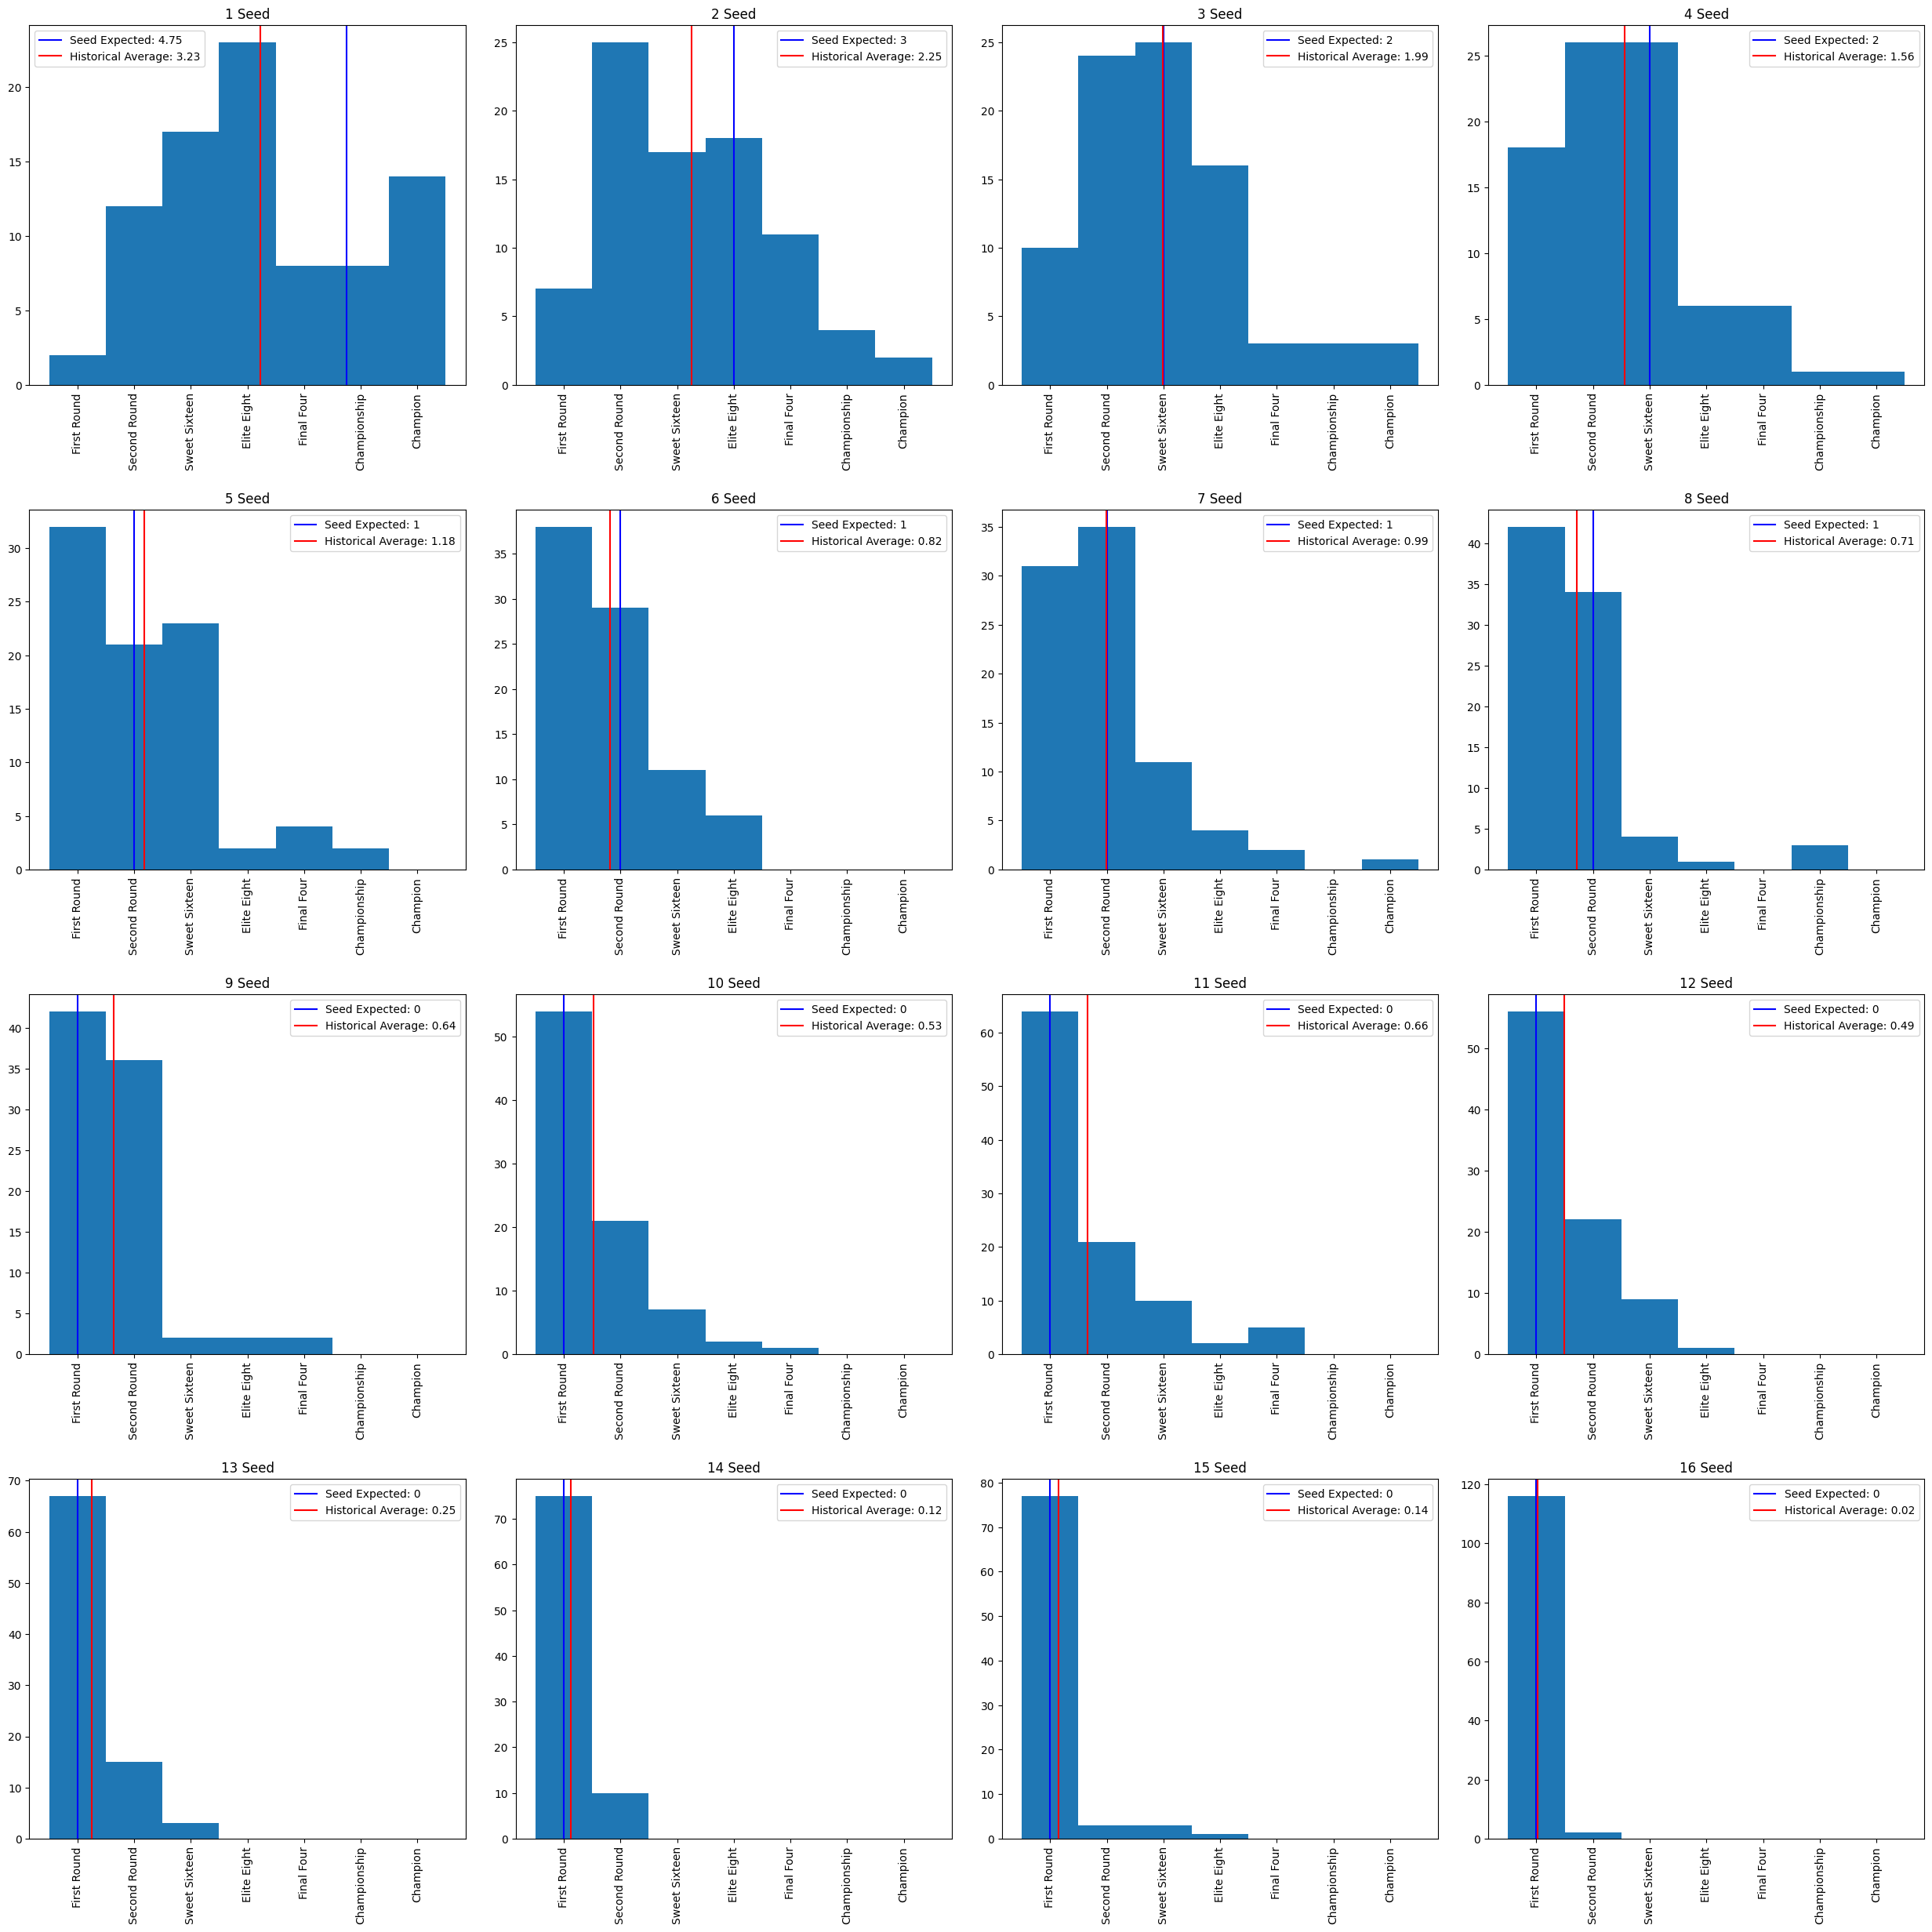

In [11]:
BIN_OFFSET = 0.5
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
ax = ax.flatten()
for seed, seed_df in tourney_teams[["ExitRound", "Seed", "RoundWinsNum"]].groupby("Seed"):
    seed_axis = ax[int(seed) - 1]
    seed_df = seed_df.sort_values(["RoundWinsNum"])
    print(seed_df)
    n, bins, patches = seed_axis.hist(seed_df["RoundWinsNum"], bins=range(0, 8))
    hist_avg = sum([count * rnd for count, rnd in zip(n, bins)]) / sum(n)
    seed_historical_perf[int(seed)] = hist_avg       
    seed_axis.set_title(f"{int(seed)} Seed")
    seed_axis.axvline(x = seed_exp_perf[int(seed)] + BIN_OFFSET, color = 'b', label = f'Seed Expected: {seed_exp_perf[int(seed)]}')
    seed_axis.axvline(x = hist_avg + BIN_OFFSET, color = 'r', label = f'Historical Average: {hist_avg:.2f}')
    seed_axis.set_xticks(ticks = [p._x0 + BIN_OFFSET for p in patches], labels = list(round_num_map.keys())[1:], rotation=90)
    seed_axis.legend()
fig.tight_layout(pad = 2)
plt.show()

In [12]:
tourney_teams[tourney_teams["RoundWinsNum"] > tourney_teams["Seed"].map(seed_exp_perf)][["TeamID", "Seed", "ExitRound", "RoundWinsNum", "Performance"]]

,TeamID,Seed,ExitRound,RoundWinsNum,Performance
10,1113,10.0,Second Round,1.0,0.166667
16,1120,10.0,Sweet Sixteen,2.0,0.333333
32,1139,12.0,Sweet Sixteen,2.0,0.333333
34,1141,11.0,Second Round,1.0,0.166667
55,1163,5.0,Sweet Sixteen,2.0,0.333333
...,...,...,...,...,...
7475,1332,11.0,Second Round,1.0,0.166667
7488,1345,1.0,Championship,5.0,0.833333
7504,1361,5.0,Sweet Sixteen,2.0,0.333333
7542,1401,9.0,Second Round,1.0,0.166667


In [13]:
tourney_teams["ExceedExp"] = tourney_teams["RoundWinsNum"] > tourney_teams["Seed"].map(seed_exp_perf)

In [14]:
tourney_teams[["TeamID", "Seed", "ExitRound", "RoundWinsNum", "Performance", "ExceedExp"]].head(5)

,TeamID,Seed,ExitRound,RoundWinsNum,Performance,ExceedExp
2,1104,10.0,First Round,0.0,0.000000,False
9,1112,1.0,Elite Eight,3.0,0.500000,False
10,1113,10.0,Second Round,1.0,0.166667,True
16,1120,10.0,Sweet Sixteen,2.0,0.333333,True
17,1122,13.0,First Round,0.0,0.000000,False


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_33223/2227986977.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=range(1, 17), label="Seed")


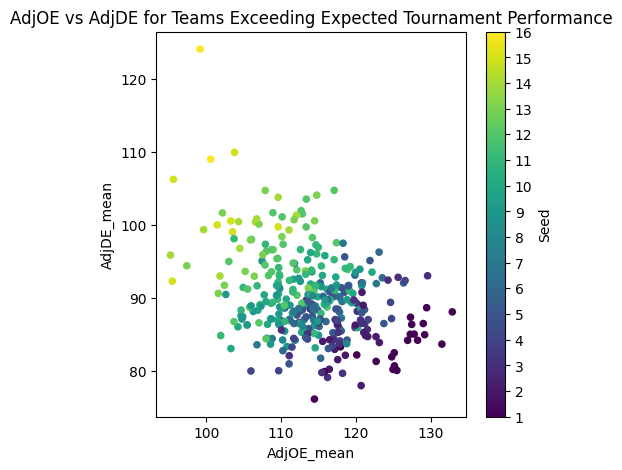

In [15]:
exceed_exp_df = tourney_teams[tourney_teams["ExceedExp"]]
# Color by seed
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(1, 16)
exceed_exp_df["color"] = exceed_exp_df["Seed"].apply(lambda x: cmap(norm(x)))
exceed_exp_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c='color', figsize=(5, 5))
plt.title("AdjOE vs AdjDE for Teams Exceeding Expected Tournament Performance")
# Configure legend for the cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 17), label="Seed")
plt.show()

# Investigate Individual Feature Importance

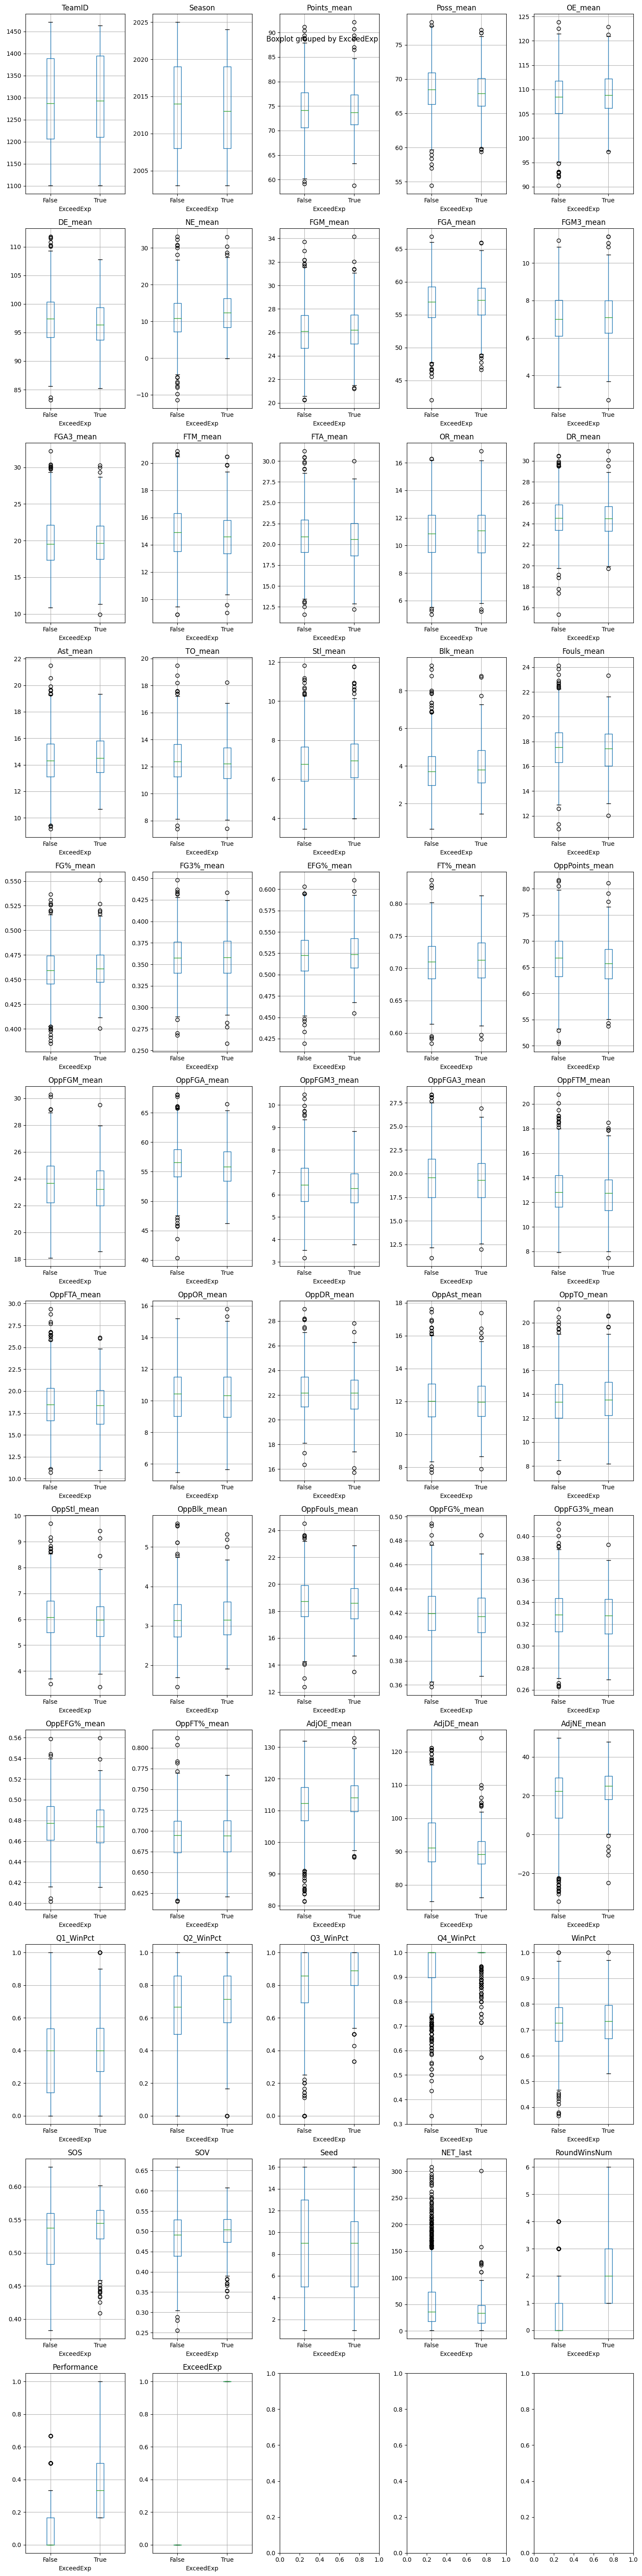

In [16]:
import math
filtered_columns = [col for col in tourney_teams.columns if not col.endswith("_stdev") and col != "ExitRound"]
rows = math.ceil(len(filtered_columns) / 5)
fig, ax = plt.subplots(nrows=rows, ncols=5, figsize=(15, 5*rows))
ax = ax.flatten().tolist()
for i, col in enumerate(filtered_columns):
    try:
        tourney_teams.boxplot(column = col, by = "ExceedExp", ax = ax[i])
        ax[i].set_title(col)
    except IndexError:
        print(f"IndexError: {i} {col}")
fig.tight_layout()
plt.show()

In [17]:
# Import HDBSCAN
from sklearn.cluster import HDBSCAN

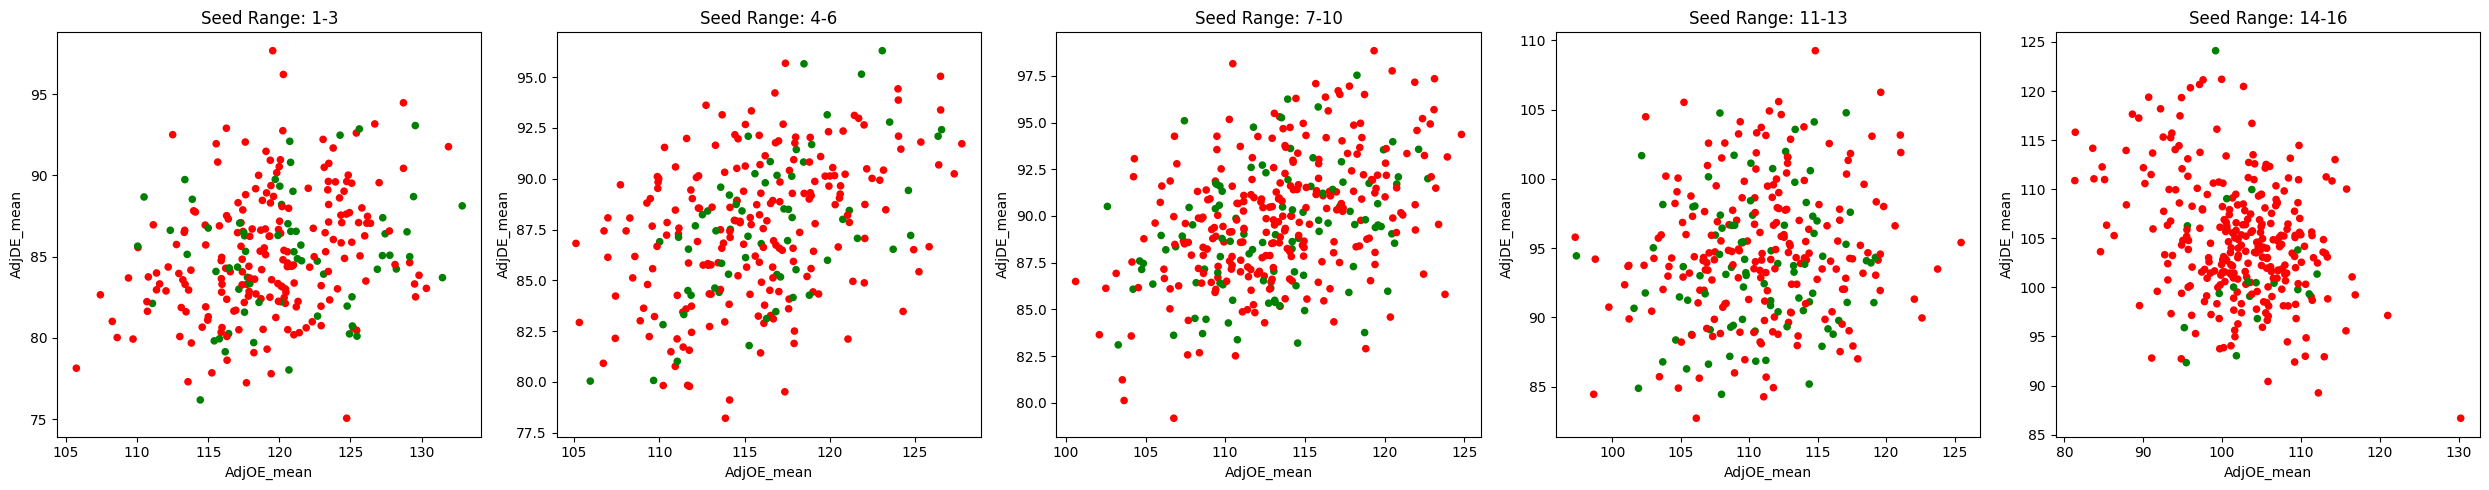

In [18]:
seed_bounds = [(1, 3), (4, 6), (7, 10), (11, 13), (14, 16)]
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax = ax.flatten()
for i, (lower, upper) in enumerate(seed_bounds):
    ax[i].set_title(f"Seed Range: {lower}-{upper}")
    seed_df = tourney_teams[(tourney_teams["Seed"] >= lower) & (tourney_teams["Seed"] <= upper)]
    colors = seed_df["ExceedExp"].map({True: "g", False: "r"})
    # Scatter plot of AdjOE vs AdjDE with color by ExceedExpColor
    seed_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c=colors, ax=ax[i])
    
    # Run HDBScan on the data
    hdb = HDBSCAN(min_cluster_size=20)
    # Plot the clusters
    hdb.fit(seed_df[["AdjOE_mean", "AdjDE_mean"]])
fig.tight_layout()



# Setup Datasets for Model Exploration

In [19]:
tourney_teams["ExceedExp"].value_counts()

False    1140
True      332
Name: ExceedExp, dtype: int64

In [20]:
X_COLS = set(tourney_teams.columns.tolist()) - { "ExceedExp", "ExitRound", "RoundWinsNum", "Performance", "Seed" }

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = tourney_teams[list(X_COLS)]
X.fillna(0, inplace=True)
Y = tourney_teams["ExceedExp"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, shuffle=True)
ss_train = MinMaxScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = MinMaxScaler()
X_test = ss_test.fit_transform(X_test)

# Methods for Feature Selection

In [22]:
SELECT_N_FEATURES = 12

In [23]:
# Basic Feature Selection for Classification
from sklearn.feature_selection import SelectKBest, f_classif

cls_selector = SelectKBest(f_classif, k=SELECT_N_FEATURES)
X_train_selected = cls_selector.fit_transform(X_train, Y_train)
X_test_selected = cls_selector.transform(X_test)

selected_features = X.columns[cls_selector.get_support()]
selected_features

Index(['AdjDE_mean', 'NET_last', 'SOV', 'SOS', 'Q3_WinPct', 'FGM_stdev',
       'AdjOE_mean', 'Q2_WinPct', 'NE_mean', 'Q4_WinPct', 'AdjNE_mean',
       'Q1_WinPct'],
      dtype='object')

In [24]:
# Feature Selection for Regression
from sklearn.feature_selection import SelectKBest, f_regression

reg_selector = SelectKBest(f_regression, k=SELECT_N_FEATURES)
X_train_selected = reg_selector.fit_transform(X_train, Y_train)
X_test_selected = reg_selector.transform(X_test)

selected_features = X.columns[reg_selector.get_support()]
selected_features

Index(['AdjDE_mean', 'NET_last', 'SOV', 'SOS', 'Q3_WinPct', 'FGM_stdev',
       'AdjOE_mean', 'Q2_WinPct', 'NE_mean', 'Q4_WinPct', 'AdjNE_mean',
       'Q1_WinPct'],
      dtype='object')

In [25]:
# L1-based Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.025, penalty="l1", dual=False, max_iter=10000).fit(X_train, Y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['AdjDE_mean'], dtype='object')

In [26]:
# Tree-based Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, Y_train)
model = SelectFromModel(clf, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['AdjDE_mean', 'NET_last', 'FTA_mean', 'SOV', 'OppFouls_stdev',
       'FT%_stdev', 'SOS', 'DE_stdev', 'AdjOE_stdev', 'Q3_WinPct',
       'OppTO_stdev', 'OppTO_mean', 'OppFG3%_stdev', 'FGA3_mean', 'AdjOE_mean',
       'Q2_WinPct', 'FT%_mean', 'EFG%_stdev', 'NE_mean', 'OppFGA3_mean',
       'TO_stdev', 'OppFG3%_mean', 'OE_stdev', 'OppFTA_mean', 'FG%_stdev',
       'AdjDE_stdev', 'OppFT%_stdev', 'FGM3_stdev', 'OppEFG%_mean', 'FTM_mean',
       'OppFTM_stdev', 'AdjNE_mean', 'Blk_mean', 'Q1_WinPct', 'OppBlk_mean',
       'OppFTM_mean', 'TeamID', 'FTM_stdev', 'OR_stdev', 'TO_mean', 'DR_stdev',
       'Blk_stdev', 'Stl_mean', 'OppAst_mean'],
      dtype='object')

In [27]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

models = {
    "Logistic Reg": LogisticRegression(),
    "Ridge": RidgeClassifier(alpha=0.5),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel="poly", degree=3, C=0.1, gamma="auto", max_iter=100000000),
    "LinearSVC": LinearSVC(max_iter=1000000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}
model_res = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall"])
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    model_res = model_res.append({
        "Model": model_name,
        "Accuracy":  accuracy_score(predictions, Y_test),
        "Precision": precision_score(predictions, Y_test),
        "Recall":    recall_score(predictions, Y_test, zero_division="warn")
    }, ignore_index=True)
print(model_res)


/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Model  Accuracy  Precision    Recall
0   Logistic Reg  0.723982       0.08  0.210526
1          Ridge  0.701357       0.16  0.250000
2  Random Forest  0.723982       0.02  0.076923
3            SVM  0.773756       0.00  0.000000
4      LinearSVC  0.651584       0.32  0.271186
5    Naive Bayes  0.502262       0.66  0.261905
6            KNN  0.746606       0.22  0.392857
7  Decision Tree  0.619910       0.54  0.306818
8        XGBoost  0.760181       0.18  0.428571


# Naive Bayes Feature Importance

In [28]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(models["Naive Bayes"], X_test, Y_test)

nb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": imps.importances_mean,
    "Std": imps.importances_std
})
nb_importances = nb_importances.sort_values("Importance", ascending=False)
nb_importances

,Feature,Importance,Std
85,TO_mean,0.016290,0.004614
81,OppFGA3_stdev,0.014480,0.008774
22,OppFGA_mean,0.012670,0.004433
16,OppPoints_mean,0.011765,0.003620
89,OE_mean,0.008145,0.008774
...,...,...,...
0,AdjDE_mean,-0.021719,0.012605
3,SOV,-0.024434,0.010554
18,SOS,-0.030769,0.013843
26,Q3_WinPct,-0.032579,0.010860


## Looking at XGB Boost Feature Importance

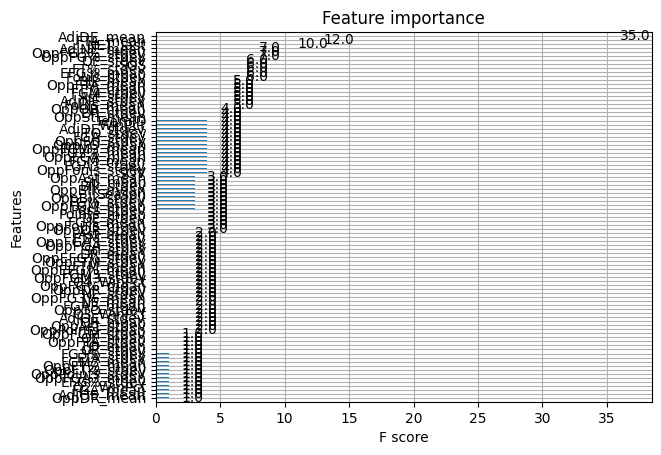

In [29]:
# XGBoost Feature Importance
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=X.columns.tolist())
xgb.plot_importance(xgb.train({}, dtrain))
plt.show()

# Predicting Exit Round with Different Basic Regression Models

In [30]:
X.columns

Index(['AdjDE_mean', 'NET_last', 'FTA_mean', 'SOV', 'Fouls_mean',
       'OppFouls_stdev', 'OppOR_stdev', 'AdjNE_stdev', 'Fouls_stdev',
       'Ast_stdev', 'OppFouls_mean', 'OppFG%_stdev', 'EFG%_mean', 'FGA3_stdev',
       'FT%_stdev', 'OppDR_mean', 'OppPoints_mean', 'OppAst_stdev', 'SOS',
       'FGM_mean', 'FG%_mean', 'DE_stdev', 'OppFGA_mean', 'FG3%_mean',
       'OR_mean', 'AdjOE_stdev', 'Q3_WinPct', 'OppFGM3_mean', 'Poss_mean',
       'OppTO_stdev', 'OppTO_mean', 'FGM_stdev', 'OppFG3%_stdev',
       'Points_mean', 'FGA3_mean', 'DE_mean', 'AdjOE_mean', 'OppStl_stdev',
       'Poss_stdev', 'FGA_mean', 'Q2_WinPct', 'OppFGM_mean', 'FT%_mean',
       'EFG%_stdev', 'NE_mean', 'FGA_stdev', 'OppFGA3_mean', 'TO_stdev',
       'OppFG3%_mean', 'OE_stdev', 'OppFTA_mean', 'NE_stdev', 'FG%_stdev',
       'AdjDE_stdev', 'OppDR_stdev', 'OppPoints_stdev', 'OppFT%_stdev',
       'OppBlk_stdev', 'Points_stdev', 'OppFG%_mean', 'Q4_WinPct',
       'OppFGM3_stdev', 'FGM3_stdev', 'OppFT%_mean', 'OppEFG%

In [31]:
# Scale features per column
X_scaled = StandardScaler().fit_transform(X)
# Performance
Y_sern = tourney_teams["Performance"]


In [32]:
X.describe()

,AdjDE_mean,NET_last,FTA_mean,SOV,Fouls_mean,OppFouls_stdev,OppOR_stdev,AdjNE_stdev,Fouls_stdev,Ast_stdev,...,OppFTA_stdev,Ast_mean,OppStl_mean,OE_mean,DR_stdev,OppOR_mean,Blk_stdev,OppFGM_stdev,Stl_mean,OppAst_mean
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,...,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,92.506302,52.056386,20.910646,0.485994,17.528662,4.129468,3.728854,19.761966,3.909502,4.225547,...,6.989889,14.437457,6.084316,108.522057,4.685765,10.291539,2.102311,4.152062,6.880798,12.087698
std,8.173394,53.112379,2.887706,0.059324,1.817639,0.597566,0.607761,2.730421,0.566781,0.688902,...,1.088974,1.829587,0.913681,4.956240,0.646883,1.780129,0.471366,0.593195,1.349401,1.517131
min,75.063123,1.000000,11.583333,0.255604,10.941176,2.468349,2.161821,11.995339,2.353314,2.321695,...,3.946046,9.161290,3.387097,90.270663,3.035148,5.468750,0.603202,2.333988,3.451613,7.676471
25%,86.706973,17.000000,18.937500,0.445420,16.242163,3.736053,3.294001,17.874111,3.516582,3.751374,...,6.203842,13.175595,5.468750,105.276849,4.220793,9.000000,1.769140,3.758793,5.934946,11.083418
50%,90.592292,35.000000,20.827381,0.495438,17.500000,4.108686,3.700449,19.620226,3.887657,4.168040,...,6.960539,14.354839,6.033908,108.574322,4.642449,10.409007,2.049686,4.136558,6.818182,12.029412
75%,96.917921,62.000000,22.818182,0.529434,18.688702,4.519847,4.134409,21.566356,4.273676,4.685424,...,7.710716,15.639037,6.666667,111.861879,5.083771,11.515152,2.372587,4.539489,7.690625,13.030303
max,124.110125,308.000000,31.187500,0.658638,24.125000,6.426672,5.800320,28.845994,6.675078,6.923546,...,11.947774,21.484848,9.700000,123.829359,7.409819,15.793103,4.454553,6.665059,11.823529,17.625000


In [33]:
Y_sern.describe()

count    1472.000000
mean        0.149796
std         0.218486
min         0.000000
25%         0.000000
50%         0.000000
75%         0.166667
max         1.000000
Name: Performance, dtype: float64

In [34]:
# Predict ExitRoundNum with XGBoost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

reg_models = [
    ("XGBReg", XGBRegressor()),
    ("linear", LinearRegression()),
    ("SGD", SGDRegressor())
]
reg_model_res = pd.DataFrame(columns=["Model", "MAE", "MAE_std"])
for model_name, model in reg_models:
    score = cross_val_score(model, X_scaled, Y_sern, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
    reg_model_res = reg_model_res.append({
        "Model": model_name,
        "MAE": score.mean(),
        "MAE_std": score.std()
    }, ignore_index=True)
    model.fit(X_scaled, Y_sern) # Fit the model
    
reg_model_res

,Model,MAE,MAE_std
0,XGBReg,0.247741,0.093576
1,linear,0.268403,0.056873
2,SGD,0.256787,0.059597


In [37]:
# Filter the 2025 tournament teams
tourney_teams_2025 = tourney_teams[tourney_teams["Season"] == 2025]

# Scale the features for the 2025 tournament teams
X_2025 = tourney_teams_2025[list(X_COLS)]
X_2025.fillna(0, inplace=True)
X_2025_scaled = StandardScaler().fit_transform(X_2025)

# Predict the performance for the 2025 tournament teams using the regression models
reg_model_predictions = {}
for model_name, model in reg_models:
    predictions = model.predict(X_2025_scaled)
    reg_model_predictions[model_name] = predictions

# Create a DataFrame to store the results
results_df = pd.DataFrame(reg_model_predictions)
results_df["TeamID"] = tourney_teams_2025["TeamID"].values
results_df["Season"] = tourney_teams_2025["Season"].values

print(results_df)

      XGBReg        linear       SGD  TeamID  Season
0  -0.032388  6.527928e+11  0.055341    1103    2025
1   0.258843  8.441022e+10  0.271979    1104    2025
2  -0.000572 -3.099854e+10 -0.030682    1106    2025
3   0.010587 -3.911182e+11 -0.002422    1110    2025
4   0.176111  3.662813e+10  0.169187    1112    2025
..       ...           ...       ...     ...     ...
63  0.186337 -4.638032e+11  0.143014    1458    2025
64  0.031118  3.743711e+11 -0.104466    1459    2025
65  0.161033 -3.612814e+11 -0.042898    1462    2025
66 -0.015611  6.441790e+11  0.164362    1463    2025
67  0.027167  6.816313e+10  0.245253    1471    2025

[68 rows x 5 columns]


In [39]:
teams_df = pd.read_csv("/Users/andrewgrowney/Data/kaggle/marchmadness-2025/MTeams.csv")

In [40]:
merged_df = pd.merge(teams_df, results_df, on="TeamID")
print(merged_df.head())

   TeamID       TeamName  FirstD1Season  LastD1Season    XGBReg        linear  \
0    1103          Akron           1985          2025 -0.032388  6.527928e+11   
1    1104        Alabama           1985          2025  0.258843  8.441022e+10   
2    1106     Alabama St           1985          2025 -0.000572 -3.099854e+10   
3    1110  American Univ           1985          2025  0.010587 -3.911182e+11   
4    1112        Arizona           1985          2025  0.176111  3.662813e+10   

        SGD  Season  
0  0.055341    2025  
1  0.271979    2025  
2 -0.030682    2025  
3 -0.002422    2025  
4  0.169187    2025  


In [48]:
merged_df[["TeamName", "Season", "XGBReg", "linear", "SGD"]].sort_values("XGBReg", ascending=False).head(20)

,TeamName,Season,XGBReg,linear,SGD
15,Duke,2025,0.651808,-2.093270e+11,0.433604
17,Florida,2025,0.525853,1.657377e+11,0.405080
31,Maryland,2025,0.484342,-1.742639e+11,0.266458
22,Houston,2025,0.464817,2.645084e+11,0.463795
6,Auburn,2025,0.454412,3.478898e+11,0.372086
56,Texas Tech,2025,0.354080,-2.554356e+10,0.240341
55,Texas A&M,2025,0.342829,1.058915e+11,0.184149
35,Michigan St,2025,0.322312,-1.149796e+11,0.244525
51,St John's,2025,0.309290,3.504759e+11,0.319874
9,BYU,2025,0.287333,5.457909e+11,0.177710


In [35]:
ALABAMA = 1104

# Get Alabama's data
alabama_data = X_scaled[X_scaled["TeamID"] == ALABAMA & X_scaled["Season"] == 2024]
print(alabama_data)

reg_models[0][1].predict(alabama_data)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices